In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !git clone https://github.innominds.com/karoly-hars/DE_resnet_unet_hyb

In [ ]:
# !python3  DE_resnet_unet_hyb/compute_errors.py

In [2]:
dataset_path = 'drive/MyDrive/nyu_depth_v2_labeled.mat'

In [33]:
import numpy as np
import h5py
f = h5py.File(dataset_path,'r')

depths = f.get('depths')
depths = np.array(depths) # For converting to a NumPy array
depths= np.transpose(depths, (0,2,1))
# label = f.get('labels')
# label = np.array(label) # For converting to a NumPy array
# label= np.transpose(label, (0,2,1))

In [23]:
images = f.get('images')
images = np.array(images) # For converting to a NumPy array
# images = np.divide(images , 255)
images= np.transpose(images, (0,3,2,1))

In [5]:
import tensorflow as tf

In [6]:
images = tf.cast(images, tf.float16)

In [7]:
images = tf.divide(images , 255)

In [8]:
# depths = tf.divide(depths , 10) -1

In [38]:
# a = !python3 DE_resnet_unet_hyb/predict_img.py -i 'DE_resnet_unet_hyb/example_data/test_img0.jpg'


In [9]:
import torch.nn as nn
import torch
import os


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 conv layer with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_incoming_shape(incoming):
    size = incoming.size()
    # returns the incoming data shape as a list
    return [size[0], size[1], size[2], size[3]]


def interleave(tensors, axis):
    # change the first element (batch_size to -1)
    old_shape = get_incoming_shape(tensors[0])[1:]
    new_shape = [-1] + old_shape

    # double 1 dimension
    new_shape[axis] *= len(tensors)

    # pack the tensors on top of each other
    stacked = torch.stack(tensors, axis+1)

    # reshape and return
    reshaped = stacked.view(new_shape)
    return reshaped


class UnpoolingAsConvolution(nn.Module):
    def __init__(self, inplanes, planes):
        super(UnpoolingAsConvolution, self).__init__()

        # interleaving convolutions
        self.conv_A = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 3), stride=1, padding=1)
        self.conv_B = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 3), stride=1, padding=0)
        self.conv_C = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 2), stride=1, padding=0)
        self.conv_D = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 2), stride=1, padding=0)

    def forward(self, x):
        output_a = self.conv_A(x)

        padded_b = nn.functional.pad(x, (1, 1, 0, 1))
        output_b = self.conv_B(padded_b)

        padded_c = nn.functional.pad(x, (0, 1, 1, 1))
        output_c = self.conv_C(padded_c)

        padded_d = nn.functional.pad(x, (0, 1, 0, 1))
        output_d = self.conv_D(padded_d)

        left = interleave([output_a, output_b], axis=2)
        right = interleave([output_c, output_d], axis=2)
        y = interleave([left, right], axis=3)
        return y


class UpProjection(nn.Module):
    def __init__(self, inplanes, planes):
        super(UpProjection, self).__init__()

        self.unpool_main = UnpoolingAsConvolution(inplanes, planes)
        self.unpool_res = UnpoolingAsConvolution(inplanes, planes)

        self.main_branch = nn.Sequential(
            self.unpool_main,
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=False),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )

        self.residual_branch = nn.Sequential(
            self.unpool_res,
            nn.BatchNorm2d(planes),
        )

        self.relu = nn.ReLU(inplace=False)

    def forward(self, input_data):
        x = self.main_branch(input_data)
        res = self.residual_branch(input_data)
        x += res
        x = self.relu(x)
        return x


class ConConv(nn.Module):
    def __init__(self, inplanes_x1, inplanes_x2, planes):
        super(ConConv, self).__init__()
        self.conv = nn.Conv2d(inplanes_x1 + inplanes_x2, planes, kernel_size=1, bias=True)

    def forward(self, x1, x2):
        x1 = torch.cat([x2, x1], dim=1)
        x1 = self.conv(x1)
        return x1


class ResnetUnetHybrid(nn.Module):
    def __init__(self, block, layers):
        self.inplanes = 64

        # resnet layers
        super(ResnetUnetHybrid, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # additional up projection layers parts
        self.conv2 = nn.Conv2d(2048, 1024, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(1024)

        self.up_proj1 = UpProjection(1024, 512)
        self.up_proj2 = UpProjection(512, 256)
        self.up_proj3 = UpProjection(256, 128)
        self.up_proj4 = UpProjection(128, 64)

        self.drop = nn.Dropout(0.5, False)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True)

        # padding + concat for unet stuff
        self.con_conv1 = ConConv(1024, 512, 512)
        self.con_conv2 = ConConv(512, 256, 256)
        self.con_conv3 = ConConv(256, 128, 128)
        self.con_conv4 = ConConv(64, 64, 64)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x_to_conv4 = self.relu(x)

        x = self.maxpool(x_to_conv4)
        x_to_conv3 = self.layer1(x)
        x_to_conv2 = self.layer2(x_to_conv3)
        x_to_conv1 = self.layer3(x_to_conv2)
        x = self.layer4(x_to_conv1)

        # additional layers
        x = self.conv2(x)
        x = self.bn2(x)

        # up project part
        x = self.up_proj1(x)
        x = self.con_conv1(x, x_to_conv1)

        x = self.up_proj2(x)
        x = self.con_conv2(x, x_to_conv2)

        x = self.up_proj3(x)
        x = self.con_conv3(x, x_to_conv3)

        x = self.up_proj4(x)
        x = self.con_conv4(x, x_to_conv4)

        x = self.drop(x)
        x = self.conv3(x)
        x = self.relu(x)

        return x

    @classmethod
    def load_pretrained(cls, device, load_path='hyb_net_weights.model'):
        model = cls(Bottleneck, [3, 4, 6, 3])

        # download the weights if they are not present
        if not os.path.exists(load_path):
            print('Downloading model weights...')
            os.system('wget https://www.dropbox.com/s/amad4ko9opi4kts/hyb_net_weights.model')

        model = model.to(device)
        model.load_state_dict(torch.load(load_path, map_location=device))

        return model


In [10]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from torchvision import transforms


HEIGHT = 256
WIDTH = 320


def scale_image(img, scale=None):
    """Resize/scale an image. If a scale is not provided, scale it closer to HEIGHT x WIDTH."""
    # if scale is None, scale to the longer size
    if scale is None:
        scale = max(WIDTH / img.shape[1], HEIGHT / img.shape[0])

    new_size = (math.ceil(img.shape[1] * scale), math.ceil(img.shape[0] * scale))
    image = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    return image


def center_crop(img):
    """Center crop an image to HEIGHT x WIDTH."""
    corner = ((img.shape[0] - HEIGHT) // 2, (img.shape[1] - WIDTH) // 2)
    img = img[corner[0]:corner[0] + HEIGHT, corner[1]:corner[1] + WIDTH]
    return img


def img_transform(img):
    """Normalize an image."""
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = data_transform(img)
    return img


def show_img_and_pred(img, depth):
    """Plot an image and a corresponding prediction next to each other."""
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    pred = np.transpose(depth, (1, 2, 0))
    plt.imshow(pred[:, :, 0])
    plt.show()
    


def depth_to_grayscale(depth, max_dist=10.0):
    """Transform a prediction into a grayscale 8-bit image."""
    depth = np.transpose(depth, (1, 2, 0))
    depth[depth > max_dist] = max_dist
    depth = depth / max_dist

    depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR)
    bgr_depth_img = np.clip(bgr_depth_img, 0, 255)
    return bgr_depth_img


In [28]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from torchvision import transforms


HEIGHT = 256
WIDTH = 320


def scale_image(img, scale=None):
    """Resize/scale an image. If a scale is not provided, scale it closer to HEIGHT x WIDTH."""
    # if scale is None, scale to the longer size
    if scale is None:
        scale = max(WIDTH / img.shape[1], HEIGHT / img.shape[0])

    new_size = (math.ceil(img.shape[1] * scale), math.ceil(img.shape[0] * scale))
    image = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    return image


def center_crop(img):
    """Center crop an image to HEIGHT x WIDTH."""
    corner = ((img.shape[0] - HEIGHT) // 2, (img.shape[1] - WIDTH) // 2)
    img = img[corner[0]:corner[0] + HEIGHT, corner[1]:corner[1] + WIDTH]
    return img


def img_transform(img):
    """Normalize an image."""
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = data_transform(img)
    return img


def show_img_and_pred(img, depth):
    """Plot an image and a corresponding prediction next to each other."""
    plt.figure(figsize = (12 ,6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    pred = np.transpose(depth, (1, 2, 0))
    plt.imshow(pred[:, :, 0] ,  cmap=plt.cm.gist_rainbow)

    plt.show()
    


def depth_to_grayscale(depth, max_dist=10.0):
    """Transform a prediction into a grayscale 8-bit image."""
    depth = np.transpose(depth, (1, 2, 0))
    depth[depth > max_dist] = max_dist
    depth = depth / max_dist

    depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR)
    bgr_depth_img = np.clip(bgr_depth_img, 0, 255)
    return bgr_depth_img


In [29]:
import argparse
import cv2
import torch
# from network import ResnetUnetHybrid
# import image_utils


def predict_img(img):
    """Inference a single image."""
    # switch to CUDA device if possible
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Use GPU: {}'.format(str(device) != 'cpu'))

    # load model
    print('Loading model...')
    model = ResnetUnetHybrid.load_pretrained(device=device)
    model.eval()

    # load image
    # img = cv2.imread(img_path)[..., ::-1]
    img = scale_image(img)
    img = center_crop(img)
    inp = img_transform(img)
    inp = inp[None, :, :, :].to(device)

    # inference
    print('Running the image through the network...')
    output = model(inp)

    # transform and plot the results
    output = output.cpu()[0].data.numpy()
    show_img_and_pred(img, output)
    # return img , output

Use GPU: False
Loading model...
Running the image through the network...


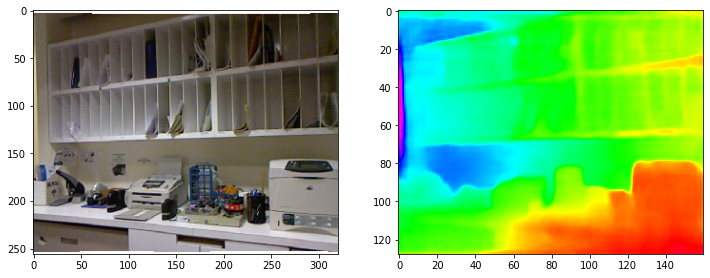

In [30]:
predict_img(images[10 ] )

In [35]:
depths.shape

(1449, 480, 640)

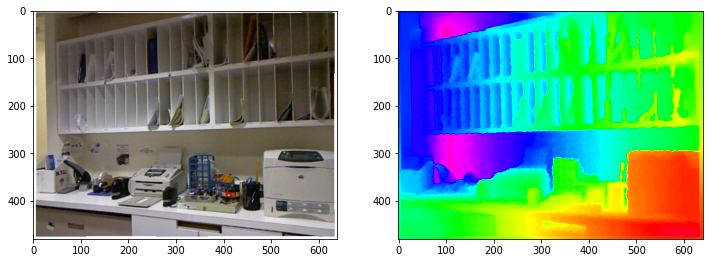

In [37]:

# show_img_and_pred(images[10 ] , depths[10 , : , : ] )
plt.figure(figsize = (12 ,6))
plt.subplot(1, 2, 1)
plt.imshow(images[10 ])

plt.subplot(1, 2, 2)
plt.imshow(depths[10 , : , : ] ,  cmap=plt.cm.gist_rainbow)

plt.show()


In [34]:
# !python DE_resnet_unet_hyb/predict_img.py -i 'DE_resnet_unet_hyb/example_data/test_img1.jpg'

Use GPU: False
Loading model...
Running the image through the network...
<Figure size 640x480 with 2 Axes>
